In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Callable, List

In [2]:
@dataclass
class Function:
    func: Callable[[float], float]
    derivative: Callable[[float], float]

In [3]:
class Perceptron:
    def __init__(
        self,
        input_layer_size: int,
        hidden_layers_sizes: tuple,
        output_layer_size: int,
        init_weights_function: Callable[[tuple], tuple],
        activation_functions: tuple,  # Кортеж функций активации для каждого скрытого слоя
        output_activation_function: Function,
        loss_function: Function,
        epochs: int,
        learning_rate: float = 0.01,
    ):
        self.input_layer_size = input_layer_size
        self.hidden_layers_sizes = hidden_layers_sizes  # Кортеж с размерами скрытых слоев
        self.output_layer_size = output_layer_size
        self.activation_functions = activation_functions  # Кортеж с функциями активации
        self.output_activation_function = output_activation_function
        self.loss_function = loss_function
        self.epochs = epochs
        self.learning_rate = learning_rate

        # Инициализация весов и смещений (biases)
        self.weights = []
        self.biases = []

        # Веса между входным слоем и первым скрытым слоем
        self.weights.append(init_weights_function((hidden_layers_sizes[0], input_layer_size)))
        self.biases.append(np.random.randn(hidden_layers_sizes[0]))

        # Веса между скрытыми слоями
        for i in range(1, len(hidden_layers_sizes)):
            self.weights.append(init_weights_function((hidden_layers_sizes[i], hidden_layers_sizes[i - 1])))
            self.biases.append(np.random.randn(hidden_layers_sizes[i]))

        # Веса между последним скрытым слоем и выходным слоем
        self.weights.append(init_weights_function((output_layer_size, hidden_layers_sizes[-1])))
        self.biases.append(np.random.randn(output_layer_size))

    def predict(self, X: np.ndarray, get_probabilities: bool = False) -> int | list:
        current_input = X

        # Прямой проход через скрытые слои с индивидуальными функциями активации
        for i in range(len(self.hidden_layers_sizes)):
            z = np.dot(self.weights[i], current_input) + self.biases[i]
            current_input = self.activation_functions[i].func(z)  # Применение индивидуальной функции активации

        # Прямой проход через выходной слой
        z = np.dot(self.weights[-1], current_input) + self.biases[-1]
        output = self.output_activation_function.func(z)

        return output if get_probabilities else int(np.argmax(output))

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        # Преобразуем метки y в формат "one-hot encoding"
        y_one_hot = np.zeros((len(y), self.output_layer_size))
        for i, label in enumerate(y):
            y_one_hot[i, label] = 1

        for epoch in range(self.epochs):
            for i in range(len(X)):
                # Прямой проход (вычисление предсказания)
                outputs = [X[i]]  # Сохраняем выходы каждого слоя
                current_input = np.array(X[i])

                # Прямой проход через скрытые слои с индивидуальными функциями активации
                for j in range(len(self.hidden_layers_sizes)):
                    z = np.dot(self.weights[j], current_input) + self.biases[j]
                    current_input = self.activation_functions[j].func(z)
                    outputs.append(current_input)

                # Прямой проход через выходной слой
                z = np.dot(self.weights[-1], current_input) + self.biases[-1]
                output = self.output_activation_function.func(z)
                outputs.append(output)

                # Вычисление ошибки и градиента функции потерь
                loss_gradient = self.loss_function.derivative(output, y_one_hot[i])

                # Обратное распространение ошибки для выходного слоя

                # Вычисление матрицы Якобиана
                jacobian = self.output_activation_function.derivative(output)

                # Градиент по логитам (умножение матрицы Якобиана на градиент функции потерь)
                delta = np.dot(jacobian, loss_gradient)
                self.weights[-1] -= self.learning_rate * np.outer(delta, outputs[-2])
                self.biases[-1] -= self.learning_rate * delta

                # Обратное распространение для скрытых слоев с индивидуальными функциями активации
                for j in range(len(self.hidden_layers_sizes) - 1, -1, -1):
                    jacobian = self.activation_functions[j].derivative(outputs[j + 1])
                    delta = np.dot(jacobian, np.dot(self.weights[j + 1].T, delta))
                    self.weights[j] -= self.learning_rate * np.outer(delta, outputs[j])
                    self.biases[j] -= self.learning_rate * delta

    def evaluate(self, X: np.ndarray, y: np.ndarray) -> float:
        correct_predictions = 0

        for i in range(len(X)):
            prediction = self.predict(X[i])
            if prediction == y[i]:
                correct_predictions += 1

        # Возвращаем долю правильных предсказаний
        return correct_predictions / len(X)

    def validate(self, X_val: np.ndarray, y_val: np.ndarray) -> float:
        total_loss = 0.0
        n = len(X_val)

        # Преобразуем метки в one-hot encoding, если это необходимо
        y_one_hot = np.zeros((len(y_val), self.output_layer_size))
        for i, label in enumerate(y_val):
            y_one_hot[i, label] = 1

        for i in range(n):
            # Прямой проход для получения предсказания
            prediction = self.predict(X_val[i], get_probabilities=True)

            # Вычисляем функцию потерь для текущего примера
            loss = self.loss_function.func(prediction, y_one_hot[i])
            total_loss += loss

        # Возвращаем среднее значение функции потерь
        return total_loss / n

In [4]:
def he_init(size):
    return np.random.randn(*size) * np.sqrt(2.0 / size[1])

def xavier_init(size):
    return np.random.randn(*size) * np.sqrt(1.0 / size[1])

In [5]:
k = 3
ReLU = Function(
    func=lambda x: np.where(x > 0, k * x, 0),
    derivative=lambda x: np.diag(np.where(x > 0, k, 0)),
)
Softmax = Function(
    func=lambda x: (lambda exp_x: exp_x / (np.sum(exp_x) + 1e-9))(np.exp(x - np.max(x))),
    derivative=lambda x: np.diagflat(x) - np.outer(x, x),
)

In [6]:
MSE = Function(
    func=lambda y_pred, y_true: np.mean((y_true - y_pred) ** 2),
    derivative=lambda y_pred, y_true: 2 * (y_pred - y_true) / y_true.size,
)
CrossEntropy = Function(
    func=lambda y_pred, y_true: -np.log(y_pred[np.argmax(y_true)] + 1e-9),
    derivative=lambda y_pred, y_true: -y_true / (y_pred + 1e-9),
)
KL_Divergence = CrossEntropy

In [7]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28**2) / 255
x_test = x_test.reshape(-1, 28**2) / 255
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

In [8]:
model_default = Perceptron(
    input_layer_size=784,  # 28**2
    hidden_layers_sizes=(512, 256, 128, 64),
    output_layer_size=10,
    init_weights_function=he_init,
    activation_functions=(ReLU, ReLU, ReLU, ReLU),
    output_activation_function=None,
    loss_function=None,
    epochs=1,
    learning_rate=1e-3,
)

In [9]:
epochs_count = 10
epoch_list = list(range(0, epochs_count + 1))

In [10]:
def get_accuracies(output_activation_function, loss_function):
    model = copy.deepcopy(model_default)
    model.output_activation_function = output_activation_function
    model.loss_function = loss_function

    accuracies = np.array([model.evaluate(x_test, y_test)])
    losses = np.array([model.validate(x_test, y_test)])
    print(accuracies[-1], losses[-1])

    for i in range(1, epochs_count + 1):
        model.fit(x_train, y_train)
        accuracies = np.append(accuracies, model.evaluate(x_test, y_test))
        losses = np.append(losses, model.validate(x_test, y_test))
        print(accuracies[-1], losses[-1])
    
    print()
    return accuracies, losses

In [11]:
ReLU_MSE = get_accuracies(ReLU, MSE)
ReLU_CrEntr = get_accuracies(ReLU, CrossEntropy)
ReLU_KLD = ReLU_CrEntr # get_accuracies(ReLU, KL_Divergence)
Softmax_MSE = get_accuracies(Softmax, MSE)
Softmax_CrEntr = get_accuracies(Softmax, CrossEntropy)
Softmax_KLD = Softmax_CrEntr  # get_accuracies(Softmax, KL_Divergence)

0.0982 20519.268585695936
0.098 0.10000000000001588
0.098 0.10000000000001588
0.098 0.10000000000001588


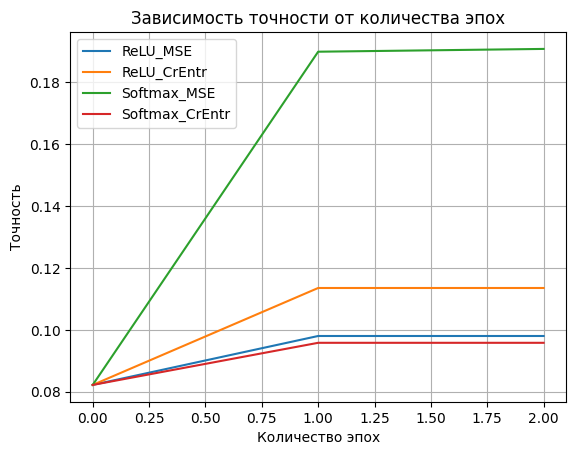

In [ ]:
plt.plot(epoch_list, ReLU_MSE[0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[0], label="Softmax_KLD")

plt.title("Зависимость точности от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Точность")
plt.grid(True)
plt.legend()
plt.show()

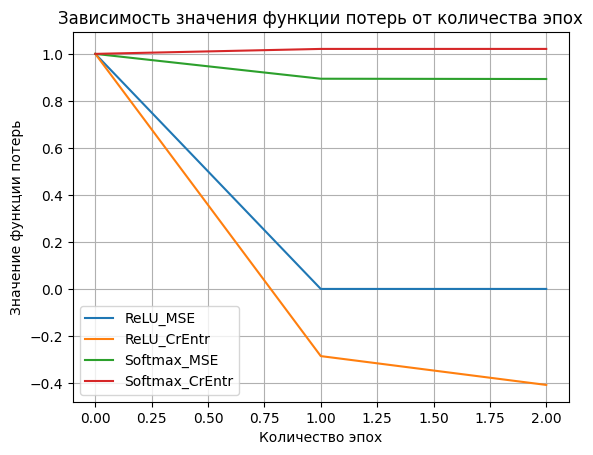

In [ ]:
plt.plot(epoch_list, ReLU_MSE[1] / ReLU_MSE[1][0], label="ReLU_MSE")
plt.plot(epoch_list, ReLU_CrEntr[1] / ReLU_CrEntr[1][0], label="ReLU_CrEntr")
# plt.plot(epoch_list, ReLU_KLD[1] / ReLU_KLD[1][0], label="ReLU_KLD")
plt.plot(epoch_list, Softmax_MSE[1] / Softmax_MSE[1][0], label="Softmax_MSE")
plt.plot(epoch_list, Softmax_CrEntr[1] / Softmax_CrEntr[1][0], label="Softmax_CrEntr")
# plt.plot(epoch_list, Softmax_KLD[1] / Softmax_KLD[1][0], label="Softmax_KLD")

plt.title("Зависимость значения функции потерь от количества эпох")
plt.xlabel("Количество эпох")
plt.ylabel("Значение функции потерь")
plt.grid(True)
plt.legend()
plt.show()